In [106]:
#Alright, we've got our data!  Now let's get down to business.
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.read_csv("FinalProjectDataALL.csv")
profile = ProfileReport(df, title="Financial Sentiment Analysis")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [107]:
counts = df['Symbol'].value_counts()
counts

TSLA       24
TM         24
SOLO       24
CENN       24
RIDE       24
GOEV       24
ARVL       24
NKLA       24
FSR        24
PII        24
0175.HK    24
TTM        24
HYMTF      24
NIO        24
RACE       24
HMC        24
STLA       24
F          24
GM         24
FUV        24
Name: Symbol, dtype: int64

In [108]:
import ml_collections
def model_config():
    cfg_dictionary = {
        "model_path": "models/bert_model.h5",
        "model_type": "transformer",

        "test_size": 0.1,
        "validation_size":0.2,
        "train_batch_size": 32,
        "eval_batch_size": 32,

        "epochs": 5,
        "adam_epsilon": 1e-8,
        "lr": 5e-6,
        "num_warmup_steps": 10,

        "max_length": 128,
        "random_seed": 42,
        "num_labels": 3,
        "model_checkpoint":"roberta-base",
    }
    cfg = ml_collections.FrozenConfigDict(cfg_dictionary)

    return cfg
cfg = model_config()

In [114]:
#importing required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import numpy as np
import ast

# Simplify the dataset into only what we care about
dataframe = df.filter(['Stock History', 'Sentiment Score', 'Stock Future'])

scale = lambda x: minmax_scaling(x, columns=0)
nump = lambda x: np.array(x, dtype=np.float32)
make_float = lambda x: float(x)
#df['Tags'] = df.Tags.apply(lambda x: x[1:-1].split(','))
def is_ERR(x):
    if 'ERR' in x:
        #print('X is Err! at ' + str(x.index('ERR')))
        return 0
    else:
        return x
dataframe['Stock History'] = dataframe['Stock History'].apply(ast.literal_eval)
dataframe['Stock History'] = dataframe['Stock History'].apply(is_ERR)
#Remove rows without good stock data
dataframe = dataframe[dataframe['Stock History'] != 0]
dataframe = dataframe[dataframe['Stock Future'] != 'UNKNOWN']
dataframe['Stock History'] = dataframe['Stock History'].apply(nump)
#dataframe['Stock History'] = dataframe['Stock History'].apply(scale)
dataframe['Stock Future'] = dataframe['Stock Future'].apply(make_float)
dataframe['Sentiment Score'] = dataframe['Sentiment Score'].apply(make_float)
dataframe = dataframe[:420] #Bears removing once futures are known (added now for consistency)
dataframe

,Stock History,Sentiment Score,Stock Future
0,"[86.858, 101.0, 107.85, 105.632, 102.872, 101....",5.0,1013.919983
1,"[111.1, 116.35, 121.29, 126.34, 127.24, 126.22...",-2.0,180.270004
2,"[17.6, 21.11, 21.49, 22.56, 21.38, 21.349998, ...",6.0,44.349998
3,"[4.01, 4.95, 5.39, 5.25, 5.19, 5.11, 5.11, 5.0...",-3.0,16.830000
4,"[6.35, 7.01, 7.43, 7.73, 7.12, 7.045, 7.045, 6...",2.0,15.980000
...,...,...,...
415,"[10.15, 10.15, 10.16, 10.14, 10.145, 10.145, 1...",-1.0,4.950000
416,"[9.92, 10.0, 9.97, 10.04, 10.005, 10.005, 9.97...",8.0,2.300000
417,"[6.42, 6.3, 6.75, 7.278, 9.489, 9.489, 11.7, 9...",10.0,1.700000
418,"[0.91, 0.97, 1.0, 1.01, 1.015, 1.015, 1.02, 1....",7.0,1.820000


In [115]:
#For the LTSM, we don't need the sentiment score
LTSM_df = pd.DataFrame(np.column_stack(list(zip(*dataframe['Stock History']))))
extracted_col = dataframe["Stock Future"]
LTSM_df = LTSM_df.join(extracted_col)
LTSM_df

,0,1,2,3,4,5,6,7,8,9,...,721,722,723,724,725,726,727,728,729,Stock Future
0,86.858002,101.000000,107.849998,105.632004,102.872002,101.649002,101.649002,100.426003,104.800003,96.311996,...,766.369995,801.890015,840.229980,871.599976,905.390015,913.275024,913.275024,921.159973,993.979980,1013.919983
1,111.099998,116.349998,121.290001,126.339996,127.239998,126.229996,126.229996,125.220001,119.949997,116.709999,...,161.089996,165.929993,171.889999,171.740005,171.699997,171.750000,171.750000,171.800003,172.820007,180.270004
2,17.600000,21.110001,21.490000,22.559999,21.379999,21.349998,21.349998,21.320000,20.780001,19.260000,...,40.830002,42.130001,43.849998,43.660000,44.820000,44.215000,44.215000,43.610001,44.560001,44.349998
3,4.010000,4.950000,5.390000,5.250000,5.190000,5.110000,5.110000,5.030000,4.830000,4.400000,...,15.740000,16.059999,16.580000,16.580000,16.860001,16.670000,16.670000,16.480000,17.090000,16.830000
4,6.350000,7.010000,7.430000,7.730000,7.120000,7.045000,7.045000,6.970000,7.190000,6.820000,...,15.160000,15.490000,16.660000,16.410000,16.299999,16.244999,16.244999,16.190001,16.379999,15.980000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,10.150000,10.150000,10.160000,10.140000,10.145000,10.145000,10.150000,10.150000,10.150000,10.150000,...,5.070000,5.160000,4.990000,4.930000,4.930000,4.930000,4.870000,5.040000,4.890000,4.950000
416,9.920000,10.000000,9.970000,10.040000,10.005000,10.005000,9.970000,9.950000,9.950000,9.950000,...,2.770000,2.710000,2.510000,2.470000,2.470000,2.470000,2.430000,2.440000,2.330000,2.300000
417,6.420000,6.300000,6.750000,7.278000,9.489000,9.489000,11.700000,9.370500,10.948500,10.837500,...,1.770000,1.770000,1.740000,1.670000,1.670000,1.670000,1.600000,1.660000,1.590000,1.700000
418,0.910000,0.970000,1.000000,1.010000,1.015000,1.015000,1.020000,1.050000,1.060000,1.040000,...,1.910000,1.930000,1.940000,1.910000,1.910000,1.910000,1.880000,1.950000,1.870000,1.820000


In [127]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(LTSM_df.T).T
scaled_data

array([[0.        , 0.01237214, 0.01836487, ..., 0.72988976, 0.7935964 ,
        0.81104093],
       [0.        , 0.05235863, 0.10162564, ..., 0.60536558, 0.61553816,
        0.68983752],
       [0.        , 0.07291235, 0.08080597, ..., 0.54029916, 0.56003329,
        0.55567095],
       ...,
       [0.22609246, 0.22102597, 0.24002533, ..., 0.02512138, 0.02216593,
        0.02681022],
       [0.        , 0.00606061, 0.00909091, ..., 0.1050505 , 0.09696969,
        0.09191919],
       [0.        , 0.00108324, 0.00085519, ..., 0.07839225, 0.06927024,
        0.06698974]])

In [130]:
from sklearn.model_selection import train_test_split
def getDataSets(lookback):
    training_np, test_np = train_test_split( scaled_data,
                                        test_size=0.1,
                                        shuffle = True)
    train_np, val_np = train_test_split( training_np,
                                        test_size=0.2,
                                        shuffle = True)
    train_x, train_y, val_x, val_y = [], [], [], []
    past_index = 730-lookback
    for i in range(0,len(train_np)):
        train_x.append(train_np[i][past_index:729])
        train_y.append(train_np[i][730])
    for i in range(0,len(val_np)):
        val_x.append(val_np[i][past_index:729])
        val_y.append(val_np[i][730])
    train_x, train_y, val_x, val_y = np.array(train_x), np.array(train_y), np.array(val_x), np.array(val_y)
    train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1],1))
    val_x = np.reshape(val_x, (val_x.shape[0],val_x.shape[1],1))
    return train_x, train_y, val_x, val_y

In [119]:
# create and fit the LSTM network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=cfg.lr),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['mse'])
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=1, validation_split = cfg.validation_size)

308/308 [==============================] - 22s 67ms/step - loss: 1.1398 - mse: 0.0429 - val_loss: 1.4507 - val_mse: 0.0607


In [120]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) #No GPU... sad :,(

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14137745109582761210
xla_global_id: -1
]


In [121]:
import sys
print (sys.version)
# 3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
2.8.0
['/device:CPU:0']


In [122]:
#Records:
# With 3e-5 lr -> 1.211 Loss
# With 1e-5 lr -> 0.1926 loss (woah)
# With 5e-6 lr -> 0.2066
# Let's play around with this and experiment.
from tqdm.auto import tqdm
metrics_results = [['Epochs', 'Learning Rate', 'Look-back', 'Loss', 'MSE']]
epochs_to_try = [4,5,6,8]
rates_to_try = [3e-5,2.5e-5,2e-5,1.5e-5]
look_to_try = [30,120,365,730]
progress_bar = tqdm(
        range(len(epochs_to_try) * len(rates_to_try) * len(look_to_try)),
    )
for epoch in epochs_to_try:
    for rate in rates_to_try:
        for look in look_to_try:
            print(f"Training model {epoch}, {rate}, {look}.")
            x_train, y_train, x_val, y_val = getDataSets(look)
            model = Sequential()
            model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
            model.add(LSTM(units=50))
            model.add(Dense(1))
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['mse'])
            model.fit(x_train, y_train, epochs=epoch, batch_size=1, verbose=1, validation_split = cfg.validation_size)
            metrics = model.evaluate(x_val, y_val)
            metrics_results.append([epoch, rate, look, metrics[0], metrics[1]])
            progress_bar.update(1)
metrics_results

  0%|          | 0/64 [00:00<?, ?it/s]

Training model 4, 3e-05, 30.
Epoch 1/4
308/308 [==============================] - 4s 8ms/step - loss: 0.1944 - mse: 0.0233 - val_loss: 0.1995 - val_mse: 0.0248
Epoch 2/4
308/308 [==============================] - 2s 6ms/step - loss: 0.1605 - mse: 0.0127 - val_loss: 0.1617 - val_mse: 0.0104
Epoch 3/4
308/308 [==============================] - 2s 6ms/step - loss: 0.1363 - mse: 0.0031 - val_loss: 0.1390 - val_mse: 8.0543e-04
Epoch 4/4
3/3 [==============================] - 0s 6ms/step - loss: 0.1369 - mse: 6.9371e-04
Training model 4, 3e-05, 120.
Epoch 1/4
308/308 [==============================] - 8s 21ms/step - loss: 0.1887 - mse: 0.0216 - val_loss: 0.1891 - val_mse: 0.0214
Epoch 2/4
308/308 [==============================] - 6s 20ms/step - loss: 0.1516 - mse: 0.0091 - val_loss: 0.1499 - val_mse: 0.0055
Epoch 3/4
308/308 [==============================] - 6s 20ms/step - loss: 0.1329 - mse: 0.0012 - val_loss: 0.1431 - val_mse: 0.0011
Epoch 4/4
3/3 [==============================] - 0s 16

3/3 [==============================] - 1s 108ms/step - loss: 1.6136 - mse: 0.0870
Training model 5, 2e-05, 30.
Epoch 1/5
308/308 [==============================] - 4s 8ms/step - loss: 0.5415 - mse: 0.0384 - val_loss: 0.3172 - val_mse: 0.0495
Epoch 2/5
308/308 [==============================] - 2s 7ms/step - loss: 0.2411 - mse: 0.0325 - val_loss: 0.2662 - val_mse: 0.0427
Epoch 3/5
308/308 [==============================] - 2s 7ms/step - loss: 0.2109 - mse: 0.0277 - val_loss: 0.2347 - val_mse: 0.0359
Epoch 4/5
308/308 [==============================] - 2s 7ms/step - loss: 0.1906 - mse: 0.0229 - val_loss: 0.2103 - val_mse: 0.0287
Epoch 5/5
3/3 [==============================] - 1s 6ms/step - loss: 0.2014 - mse: 0.0271
Training model 5, 2e-05, 120.
Epoch 1/5
308/308 [==============================] - 9s 24ms/step - loss: 0.2338 - mse: 0.0310 - val_loss: 0.2370 - val_mse: 0.0367
Epoch 2/5
308/308 [==============================] - 7s 22ms/step - loss: 0.1887 - mse: 0.0221 - val_loss: 0.2035

3/3 [==============================] - 1s 52ms/step - loss: 0.1367 - mse: 7.2639e-04
Training model 6, 2e-05, 730.
Epoch 1/6
308/308 [==============================] - 47s 149ms/step - loss: 1.1398 - mse: 0.0463 - val_loss: 1.4507 - val_mse: 0.0654
Epoch 2/6
308/308 [==============================] - 45s 147ms/step - loss: 1.1398 - mse: 0.0463 - val_loss: 1.4507 - val_mse: 0.0654
Epoch 3/6
308/308 [==============================] - 45s 147ms/step - loss: 1.1398 - mse: 0.0463 - val_loss: 1.4507 - val_mse: 0.0654
Epoch 4/6
308/308 [==============================] - 45s 147ms/step - loss: 1.1398 - mse: 0.0463 - val_loss: 1.4507 - val_mse: 0.0654
Epoch 5/6
308/308 [==============================] - 45s 147ms/step - loss: 1.1398 - mse: 0.0463 - val_loss: 1.4507 - val_mse: 0.0654
Epoch 6/6
3/3 [==============================] - 1s 102ms/step - loss: 1.6136 - mse: 0.0793
Training model 6, 1.5e-05, 30.
Epoch 1/6
308/308 [==============================] - 4s 8ms/step - loss: 0.2309 - mse: 0.031

Epoch 7/8
308/308 [==============================] - 7s 22ms/step - loss: 0.1295 - mse: 4.5034e-04 - val_loss: 0.1376 - val_mse: 4.9431e-04
Epoch 8/8
3/3 [==============================] - 0s 18ms/step - loss: 0.1368 - mse: 7.3029e-04
Training model 8, 2e-05, 365.
Epoch 1/8
308/308 [==============================] - 23s 70ms/step - loss: 1.1398 - mse: 0.0468 - val_loss: 1.4507 - val_mse: 0.0662
Epoch 2/8
308/308 [==============================] - 21s 69ms/step - loss: 1.1398 - mse: 0.0468 - val_loss: 1.4507 - val_mse: 0.0662
Epoch 3/8
308/308 [==============================] - 21s 69ms/step - loss: 1.1398 - mse: 0.0468 - val_loss: 1.4507 - val_mse: 0.0662
Epoch 4/8
308/308 [==============================] - 21s 69ms/step - loss: 1.1398 - mse: 0.0468 - val_loss: 1.4507 - val_mse: 0.0662
Epoch 5/8
308/308 [==============================] - 21s 69ms/step - loss: 1.1398 - mse: 0.0468 - val_loss: 1.4507 - val_mse: 0.0662
Epoch 6/8
308/308 [==============================] - 21s 69ms/step - l

[['Epochs', 'Learning Rate', 'Look-back', 'Loss', 'MSE'],
 [4, 3e-05, 30, 0.13689221441745758, 0.0006937055732123554],
 [4, 3e-05, 120, 0.13639995455741882, 0.0005153513047844172],
 [4, 3e-05, 365, 0.18140079081058502, 0.01876753941178322],
 [4, 3e-05, 730, 0.14136935770511627, 0.0017680168384686112],
 [4, 2.5e-05, 30, 1.613599181175232, 0.08024360239505768],
 [4, 2.5e-05, 120, 0.17659299075603485, 0.016729578375816345],
 [4, 2.5e-05, 365, 1.613599181175232, 0.08001581579446793],
 [4, 2.5e-05, 730, 1.613599181175232, 0.07553836703300476],
 [4, 2e-05, 30, 0.19352522492408752, 0.023783553391695023],
 [4, 2e-05, 120, 0.13818825781345367, 0.0010563044343143702],
 [4, 2e-05, 365, 0.2570403516292572, 0.04584331437945366],
 [4, 2e-05, 730, 0.15031495690345764, 0.005404617637395859],
 [4, 1.5e-05, 30, 0.20788246393203735, 0.030290065333247185],
 [4, 1.5e-05, 120, 0.16008654236793518, 0.009666338562965393],
 [4, 1.5e-05, 365, 1.613599181175232, 0.07777731120586395],
 [4, 1.5e-05, 730, 1.6135991

Populating the interactive namespace from numpy and matplotlib


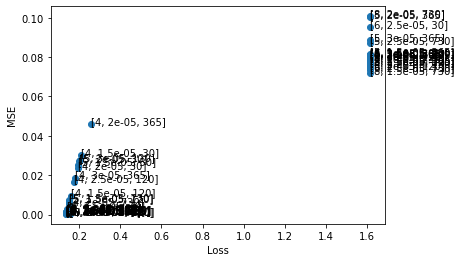

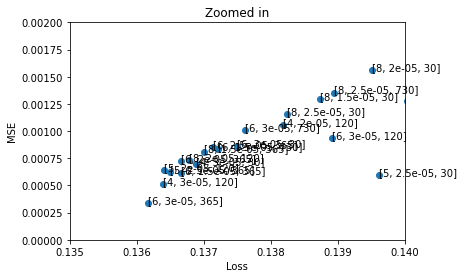

In [123]:
import matplotlib.pyplot as plt

%pylab inline
x = [val[3] for val in metrics_results[1:]]
y = [val[4] for val in metrics_results[1:]]
labels = [val[0:3] for val in metrics_results[1:]]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i in range(len(labels)):
    ax.annotate(labels[i], (x[i], y[i]))

plt.xlabel("Loss")
plt.ylabel("MSE")

plt.show()

ax3 = plt.subplot()
ax3.scatter(x, y)
ax3.set_xlabel("Loss")
ax3.set_ylabel("MSE")
ax3.set_title('Zoomed in')
ax3.set_ylim(bottom=0)
ax3.set_xlim(left=0.135)
ax3.set_ylim(top=0.002)
ax3.set_xlim(right=0.14)

for i in range(len(labels)):
    ax3.annotate(labels[i], (x[i], y[i]))

In [132]:
#Looks like there's some variance here, but some clear winners!  Mid-length timeframes are better
#and a high epoch count paired with a lr of 0.00003.  Let's take our best and see if it's reproducable.
x_train, y_train, x_val, y_val = getDataSets(365)
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
loss=tf.keras.losses.BinaryCrossentropy(),
metrics=['mse'])
model.fit(x_train, y_train, epochs=6, batch_size=1, verbose=1, validation_split = cfg.validation_size)
metrics = model.evaluate(x_val, y_val)
metrics

Epoch 1/6
241/241 [==============================] - 21s 83ms/step - loss: 0.6736 - mse: 0.0843 - val_loss: 0.4817 - val_mse: 0.0186
Epoch 2/6
241/241 [==============================] - 19s 81ms/step - loss: 0.4764 - mse: 0.0103 - val_loss: 0.4540 - val_mse: 0.0048
Epoch 3/6
241/241 [==============================] - 20s 81ms/step - loss: 0.4604 - mse: 0.0040 - val_loss: 0.4479 - val_mse: 0.0039
Epoch 4/6
241/241 [==============================] - 19s 79ms/step - loss: 0.4563 - mse: 0.0034 - val_loss: 0.4460 - val_mse: 0.0036
Epoch 5/6
241/241 [==============================] - 19s 78ms/step - loss: 0.4554 - mse: 0.0033 - val_loss: 0.4458 - val_mse: 0.0037
Epoch 6/6
3/3 [==============================] - 1s 64ms/step - loss: 0.4604 - mse: 0.0018


[0.460367351770401, 0.0017872730968520045]

AttributeError: module 'matplotlib.pyplot' has no attribute 'for_each_trace'

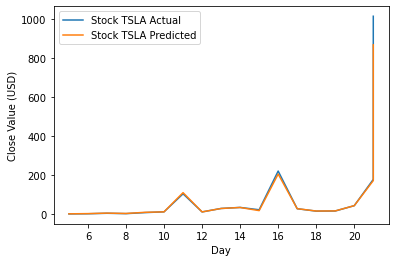

In [133]:
#Woah, looks like it.  Let's get some visualization going.
#Run the prediction
all_x, all_y = [], []
past_index = 730-365
for i in range(0,len(scaled_data)):
    all_x.append(scaled_data[i][past_index:729])
    all_y.append(scaled_data[i][730])
all_x, all_y = np.array(all_x), np.array(all_y)
all_x = np.reshape(all_x, (all_x.shape[0],all_x.shape[1],1))
#pred_y = np.reshape(pred_y, (pred_y.shape[0],pred_y.shape[1],1))
pred_y = model.predict(all_x)
#scaler.inverse_transform on the results to get the predicted stock prices
all_y_unscaled = []
pred_y_unscaled = []
for i in range(0, len(scaler.min_)-1):
    scale = MinMaxScaler()
    a, b = scaler.data_min_[i], scaler.data_max_[i]
    unscaled_y = all_y[i] * (b - a) + a
    unscaled_y_pred = pred_y[i] * (b - a) + a
    all_y_unscaled.append(unscaled_y)
    pred_y_unscaled.append(unscaled_y_pred)
#Figure out how many values are from each date
#Graph over time (There are 24 dates with 21 inputs therefore every 22nd inputs is a new day.
actual_points, pred_points = [], []
for i in range(0,len(scaled_data)-1):
    actual_points.append([21-int(i/22), all_y_unscaled[i]])
    pred_points.append([21-int(i/22), pred_y_unscaled[i][0]])

for j in range(0, 1):
    linex, liney, linex2, liney2 = [], [], [], []
    for k in range(0, 18):
        try:
            linex.append(actual_points[(k*21)+j][0])
        except:
            print(f"Error on index {(k*21)+j}.")
            print(len(actual_points))
            print(actual_points[0])
            break
        liney.append(actual_points[(k*21)+j][1])
        linex2.append(pred_points[(k*21)+j][0])
        liney2.append(pred_points[(k*21)+j][1])
    plt.plot(linex, liney, label = "Stock " + str(df['Symbol'].unique()[j]) + " Actual")
    plt.plot(linex2, liney2, label = "Stock " + str(df['Symbol'].unique()[j]) + " Predicted")
plt.xlabel("Day")
plt.ylabel("Close Value (USD)")
plt.legend()
plt.for_each_trace(lambda trace: trace.update(visible="legendonly"))
plt.show()